In [1]:
import json
import pandas as pd
import numpy as np

data = [json.loads(line) for line in open('../data/Ferrara2023-citizens-individualChallenges.json')]
data = [d for d in data if d['concept']['modelName'] != 'survey' and d['concept']['state'] in ['COMPLETED', 'FAILED']]
filtered_data = [
    {
        'user_id': d['playerId'],
        'counter': d['concept']['fields']['counterName'],
        'target': int(d['concept']['fields']['target']),
        'periodTarget': d['concept']['fields']['periodTarget'],
        'start': d['concept']['start'],
        'completed': d['concept']['completed'],
    }
    for d in data
]

df = pd.DataFrame(filtered_data)
df['start'] = pd.to_datetime(df['start'])

df = df[df['start'] < '2023-09-17']
df = df.groupby(['user_id', 'counter']).filter(lambda x: len(x) > 1)

df['periodTarget'] = df['periodTarget'].fillna(1).astype(int)
df['user_id'] = df['user_id'].astype('category')
df['counter'] = df.apply(lambda x: f"{x['counter']} repetitive" if x['periodTarget'] > 1 else x['counter'], axis=1)
df['counter'] = df['counter'].astype('category')

df['discrimination'] = df['target'] * df['periodTarget']
df['discrimination'] = df.groupby('counter', observed=False)['discrimination'].transform(lambda x: x / x.max())

df.sort_values('start', ascending=True, inplace=True, ignore_index=True)

df

,user_id,counter,target,periodTarget,start,completed,discrimination
0,u_0bea6988-bd00-4aa6-a456-4285744356ee,Walk_Km,1,1,2023-04-23 22:00:00,True,0.016393
1,u_f4b95ec9-5f53-48d8-8adf-fa61be00c967,green leaves repetitive,30,2,2023-04-23 22:00:00,True,0.038314
2,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,green leaves repetitive,30,2,2023-04-23 22:00:00,True,0.038314
3,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,Walk_Km,1,1,2023-04-23 22:00:00,True,0.016393
4,u_e4a7a7fcd26644e9961e3e05bf98454e,green leaves repetitive,30,2,2023-04-23 22:00:00,True,0.038314
...,...,...,...,...,...,...,...
5839,u_54061e0911df4785a154a10fdf6def06,green leaves repetitive,1,5,2023-09-10 22:00:00,False,0.003193
5840,u_54061e0911df4785a154a10fdf6def06,Walk_Km,1,1,2023-09-10 22:00:00,False,0.016393
5841,u_53b60c2f-f860-47ef-a905-7ee29bea6494,green leaves repetitive,5,6,2023-09-10 22:00:00,True,0.019157
5842,u_613e047decb94956a13fd01c7ddb0252,green leaves repetitive,3,5,2023-09-10 22:00:00,False,0.009579


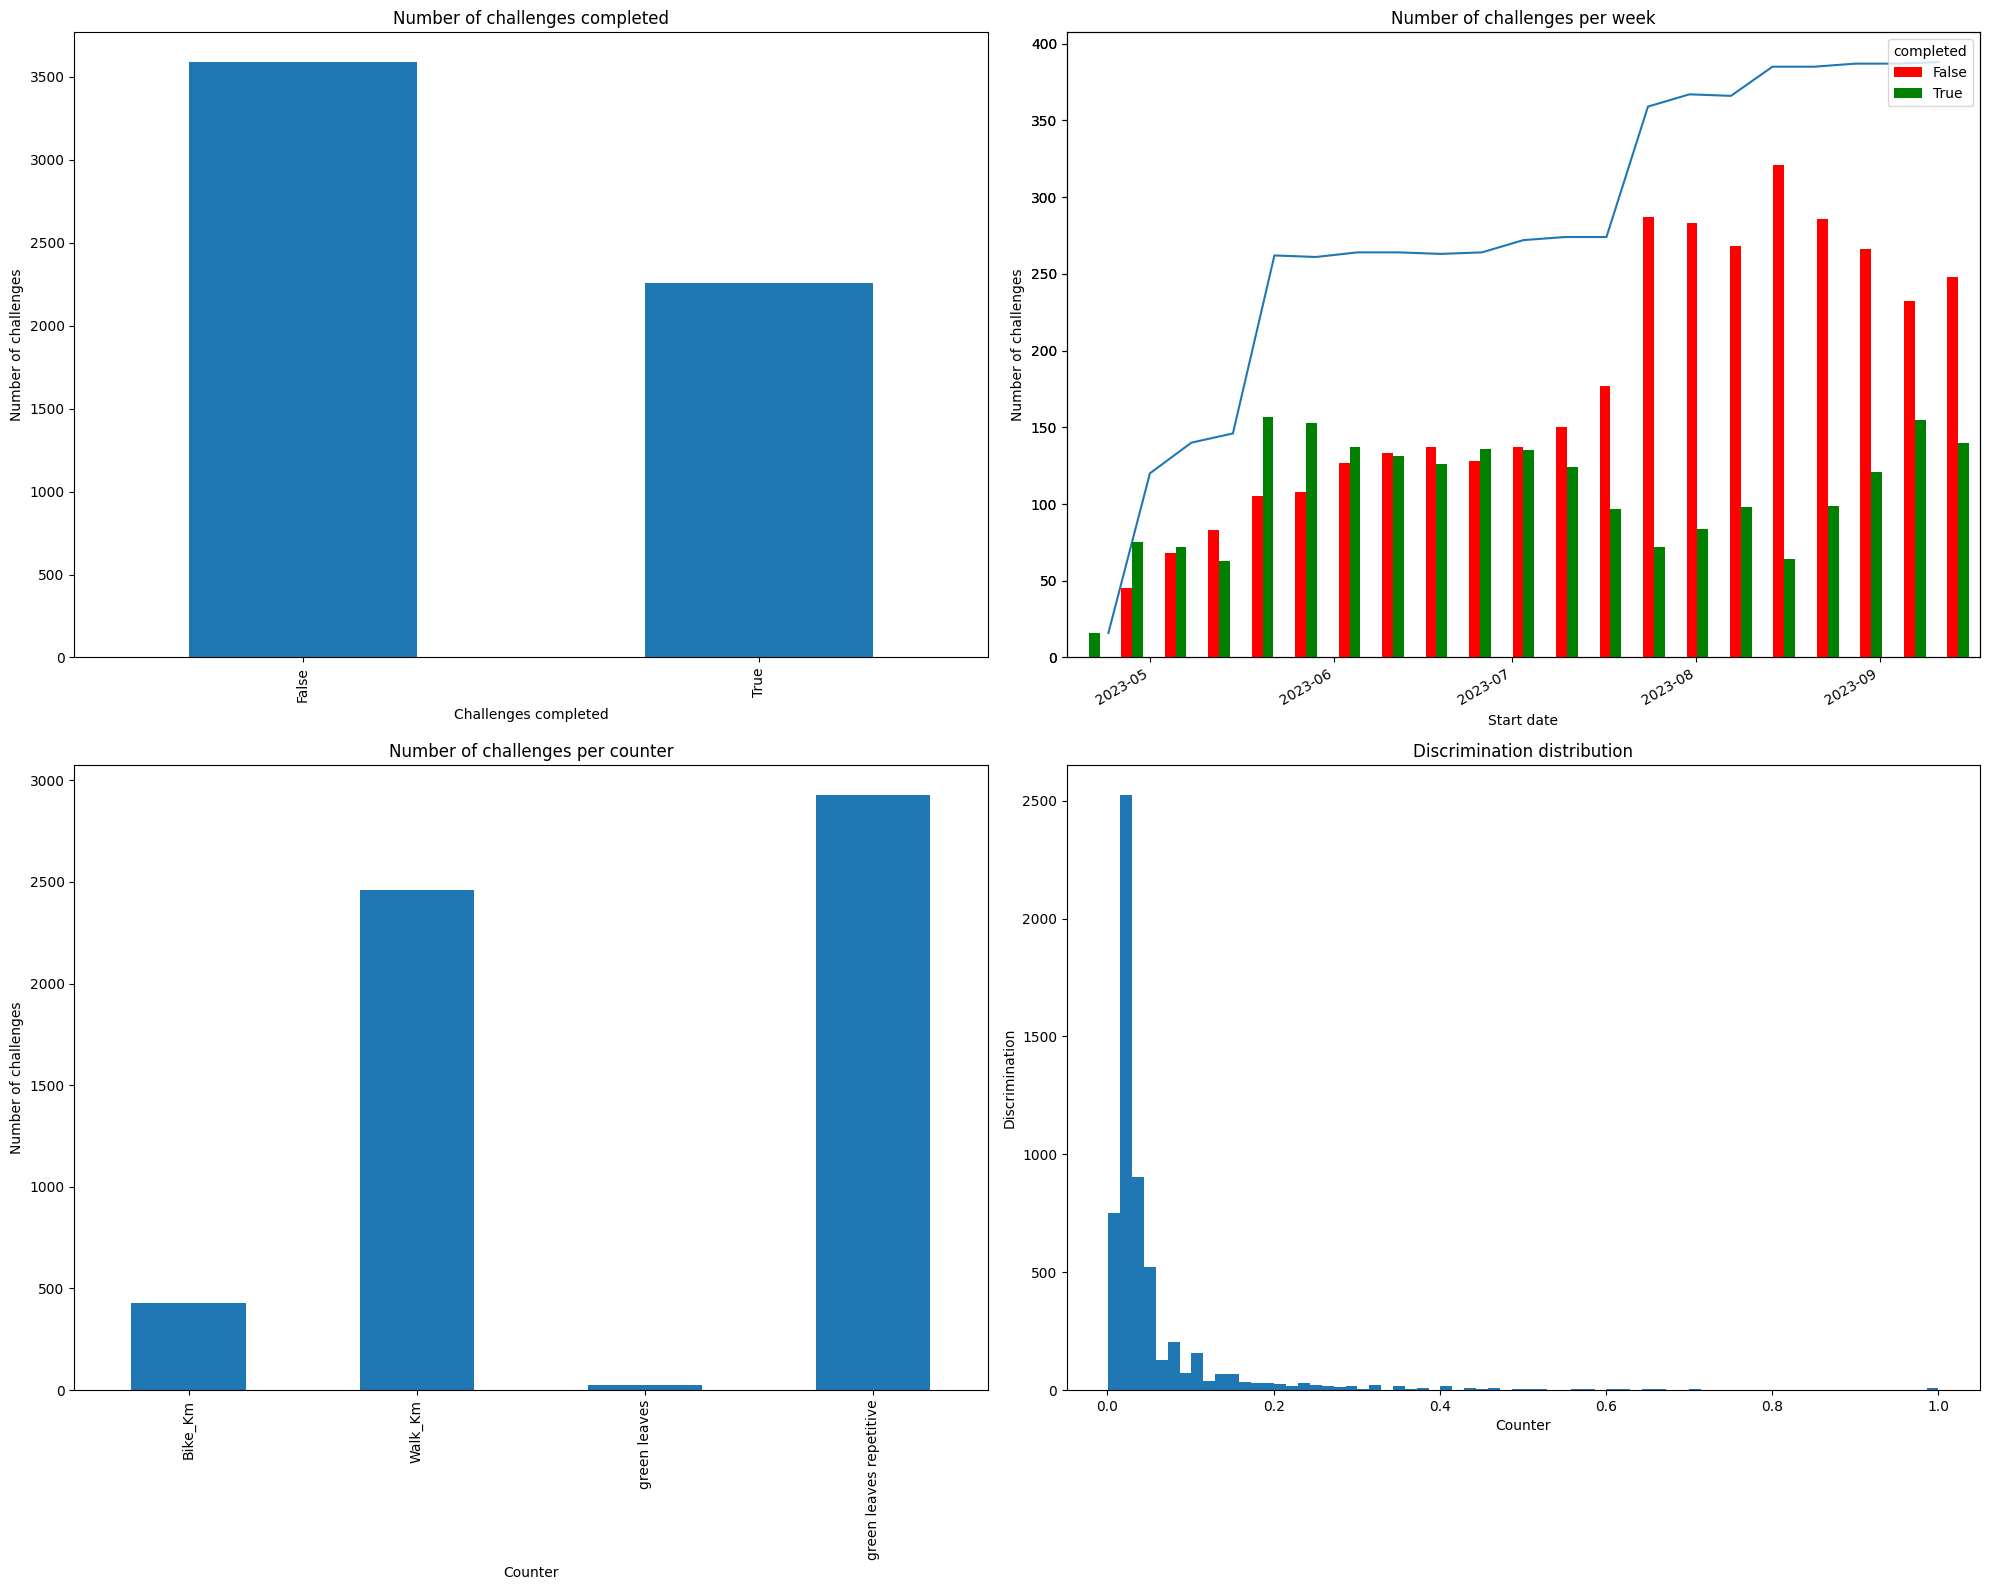

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

df['completed'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Number of challenges completed')
axs[0, 0].set_xlabel('Challenges completed')
axs[0, 0].set_ylabel('Number of challenges')

df.groupby('start').size().plot(ax=axs[0, 1])
ax3 = axs[0, 1].twiny()
df.groupby(['start', 'completed']).size().unstack().plot(ax=ax3, legend=True, stacked=False, kind='bar', color=['red', 'green'])
ax3.set_xlabel('')
ax3.set_xticks([])

axs[0, 1].set_title('Number of challenges per week')
axs[0, 1].set_xlabel('Start date')
axs[0, 1].set_ylabel('Number of challenges')

df.groupby('counter', observed=True).size().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Number of challenges per counter')
axs[1, 0].set_xlabel('Counter')
axs[1, 0].set_ylabel('Number of challenges')


df['discrimination'].plot(kind='hist', bins=70, ax=axs[1, 1])
axs[1, 1].set_title('Discrimination distribution')
axs[1, 1].set_xlabel('Counter')
axs[1, 1].set_ylabel('Discrimination')

plt.tight_layout()
plt.show()

In [3]:
dataset = pd.DataFrame({
    'user_id': df['user_id'].cat.codes,
    'counter': df['counter'].cat.codes,
    'discrimination': df['discrimination'],
    'completed': df['completed'].astype(int),
})

dataset

,user_id,counter,discrimination,completed
0,12,1,0.016393,1
1,188,3,0.038314,1
2,186,3,0.038314,1
3,186,1,0.016393,1
4,178,3,0.038314,1
...,...,...,...,...
5839,61,3,0.003193,0
5840,61,1,0.016393,0
5841,60,3,0.019157,1
5842,71,3,0.009579,0


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class Model(nn.Module):
    def __init__(self, n_users, n_indicator, n_hidden: int = 16, layers: list = [16, 8, 4], dropout: float = 0.2):
        super(Model, self).__init__()
        self.user_embedding = nn.Embedding(n_users, n_hidden)
        self.indicator_embedding = nn.Embedding(n_indicator, n_hidden)

        self.feedforward = nn.Sequential()
        for i, (in_layer, out_layer) in enumerate(zip([n_hidden, *layers], layers)):
            self.feedforward.add_module(f'linear_{i}', nn.Linear(in_layer, out_layer))
            self.feedforward.add_module(f'activation_{i}', nn.ReLU())
            self.feedforward.add_module(f'dropout_{i}', nn.Dropout(dropout))
        self.feedforward.add_module('output', nn.Linear(layers[-1], 1))
        
        self.fc = nn.Linear(2, 1)

    def forward(self, user, indicator, discrimination):
        user = self.user_embedding(user)
        indicator = self.indicator_embedding(indicator)
        x = user - indicator
        x = self.feedforward(x)
        x = torch.cat([x, discrimination.view(-1, 1)], dim=1)
        x = self.fc(x)
        return torch.sigmoid(x).view(-1)
    
    def fit(self, X: pd.DataFrame, y: pd.Series, epochs: int = 10, batch_size: int = 32, lr: float = 0.01):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCELoss()
        dataloader = DataLoader(Dataset(X, y), batch_size=batch_size, shuffle=False)
        
        for _ in (t := tqdm(range(epochs))):
            epoch_loss = 0
            for data in tqdm(dataloader, leave=False):
                user, indicator, discrimination, target = (d.to(DEVICE) for d in data)
                optimizer.zero_grad()
                output = self(user, indicator, discrimination)
                loss: torch.Tensor = criterion(output, target)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            t.set_postfix({'loss': epoch_loss / len(dataloader)})
    
    @torch.no_grad()
    def predict(self, X: pd.DataFrame, batch_size: int = 32):
        self.eval()
        dataloader = DataLoader(Dataset(X), batch_size=batch_size, shuffle=False)
        predictions = torch.tensor([]).to(DEVICE)
        for data in tqdm(dataloader):
            user, indicator, discrimination = (d.to(DEVICE) for d in data)
            output = self(user, indicator, discrimination)
            predictions = torch.cat([predictions, output])
        return predictions.detach().cpu().numpy()

class Dataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.Series = None):
        self.dataset = X
        self.y = y
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        X = self.dataset.iloc[idx]
        X = (
            torch.scalar_tensor(X['user_id'], dtype=torch.long),
            torch.scalar_tensor(X['counter'], dtype=torch.long),
            torch.scalar_tensor(X['discrimination'], dtype=torch.float32)
        )

        if self.y is None:
            return X
        
        return tuple([*X, torch.scalar_tensor(self.y.iloc[idx])])

n_users = dataset['user_id'].max() + 1
n_indicator = dataset['counter'].max() + 1

cuda


In [5]:
test_df = dataset.groupby(['user_id', 'counter']).tail(1)
train_df = dataset.drop(test_df.index)

Y_hat_df = test_df[['completed']].copy()

In [6]:
model = Model(n_users, n_indicator, n_hidden=32, dropout=0.5)
model.to(DEVICE)

model.fit(train_df[['user_id', 'counter', 'discrimination']], train_df['completed'], epochs=15, batch_size=32, lr=0.01)
Y_hat_df['model'] = model.predict(test_df[['user_id', 'counter', 'discrimination']])

Y_hat_df

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,completed,model
240,0,4.986938e-01
410,0,4.652078e-01
550,1,4.470277e-01
565,0,1.389942e-10
629,1,9.577098e-01
...,...,...
5839,0,5.014168e-04
5840,0,5.442780e-08
5841,1,3.348119e-01
5842,0,3.786923e-01


In [7]:
# Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

X = train_df[['user_id', 'counter', 'discrimination']]
y = train_df['completed']

preprocessor = ColumnTransformer(
    transformers=[
        ('user_id', OneHotEncoder(), ['user_id']),
        ('counter', OneHotEncoder(), ['counter']),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X, y)

test_X = test_df[['user_id', 'counter', 'discrimination']]
test_y = test_df['completed']

Y_hat_df['logistic'] = pipeline.predict_proba(test_X)[:, 1]

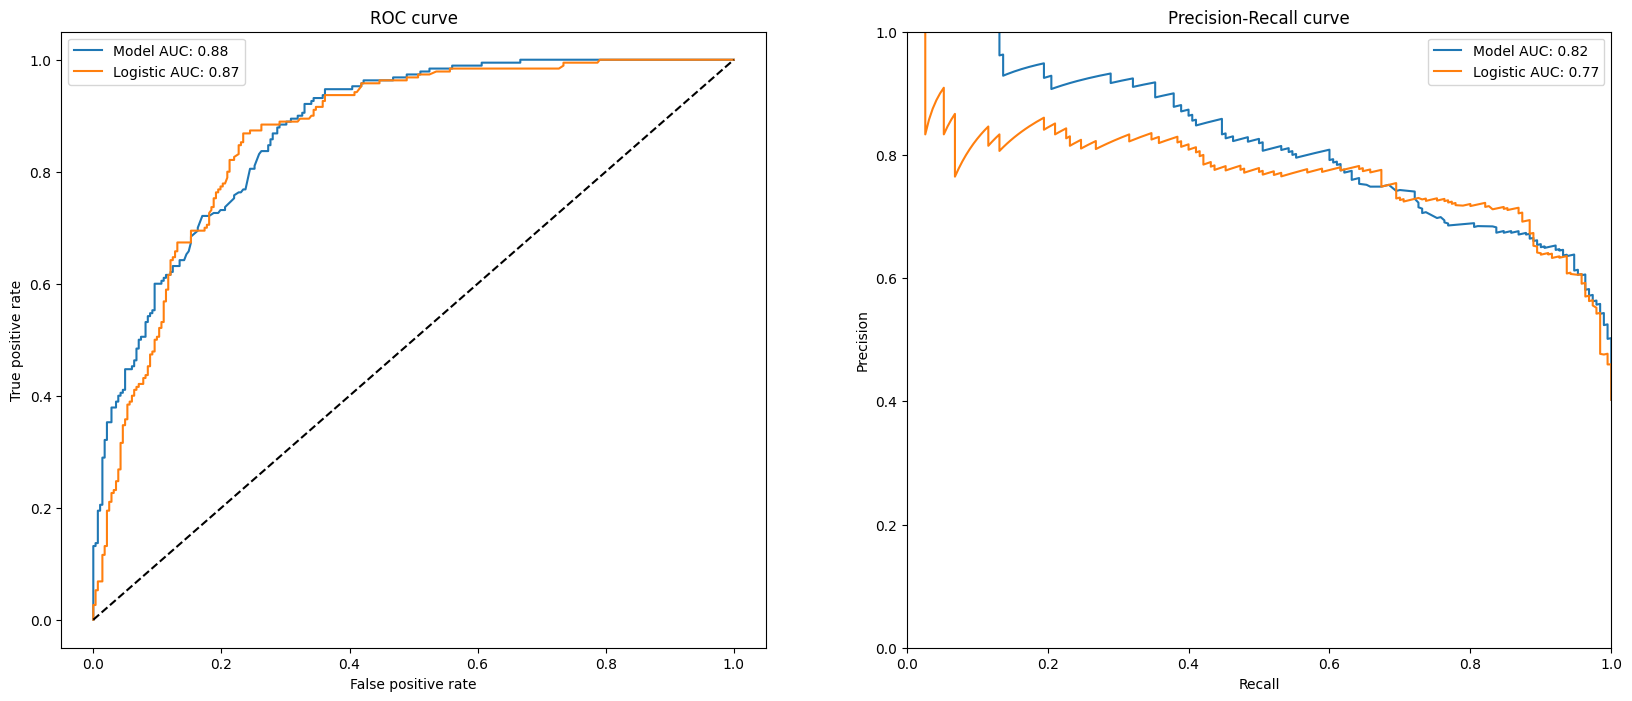

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

fpr, tpr, _ = roc_curve(Y_hat_df['completed'], Y_hat_df['model'])
ax1.plot(fpr, tpr, label=f"Model AUC: {auc(fpr, tpr):.2f}")

fpr, tpr, _ = roc_curve(Y_hat_df['completed'], Y_hat_df['logistic'])
ax1.plot(fpr, tpr, label=f"Logistic AUC: {auc(fpr, tpr):.2f}")

ax1.plot([0, 1], [0, 1], linestyle='--', color='black')
ax1.set_title('ROC curve')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend()

precision, recall, _ = precision_recall_curve(Y_hat_df['completed'], Y_hat_df['model'])
ax2.plot(recall, precision, label=f"Model AUC: {auc(recall, precision):.2f}")

precision, recall, _ = precision_recall_curve(Y_hat_df['completed'], Y_hat_df['logistic'])
ax2.plot(recall, precision, label=f"Logistic AUC: {auc(recall, precision):.2f}")

ax2.set_title('Precision-Recall curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

In [9]:
users = pd.Series(range(n_users), name='user_id')
counters = pd.Series(range(n_indicator), name='counter')
difficulty = pd.Series(np.linspace(0.1, 1, 10, endpoint=False), name='discrimination')

query = pd.merge(users, counters, how='cross').merge(difficulty, how='cross')

query['model'] = model.predict(query)
query

  0%|          | 0/243 [00:00<?, ?it/s]

,user_id,counter,discrimination,model
0,0,0,0.10,0.229721
1,0,0,0.19,0.222473
2,0,0,0.28,0.215391
3,0,0,0.37,0.208473
4,0,0,0.46,0.201720
...,...,...,...,...
7755,193,3,0.55,0.400151
7756,193,3,0.64,0.390251
7757,193,3,0.73,0.380440
7758,193,3,0.82,0.370726


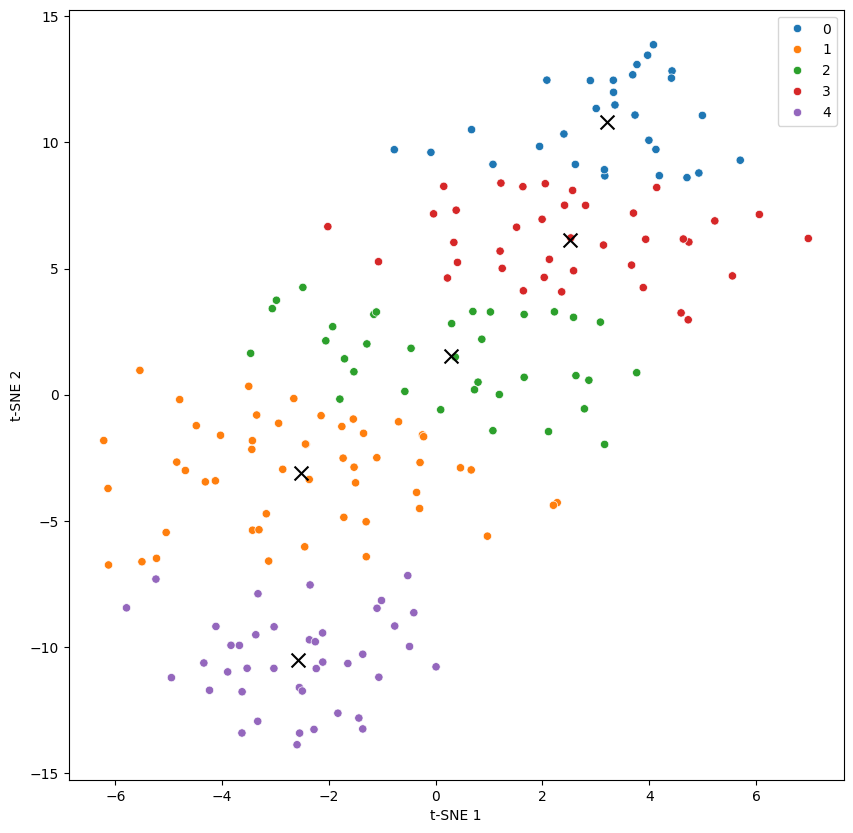

In [10]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

user_embedding = model.user_embedding.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
user_embedding_tsne = tsne.fit_transform(user_embedding)

kmeans = KMeans(n_clusters=5)
kmeans.fit(user_embedding_tsne)
clusters = kmeans.predict(user_embedding_tsne)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=user_embedding_tsne[:, 0], y=user_embedding_tsne[:, 1], hue=clusters, ax=ax, palette='tab10')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()